# Cortisol Plots

In [60]:
from pathlib import Path
import json

import pandas as pd
import numpy as np
import pingouin as pg

import biopsykit as bp
from biopsykit.stats import StatsPipeline
from biopsykit.io import load_long_format_csv
from biopsykit.utils.dataframe_handling import multi_xs

from fau_colors import cmaps, register_fausans_font

import matplotlib.pyplot as plt
import seaborn as sns

from carwatch_analysis.io import load_cortisol_samples_reporting_times
from carwatch_analysis.utils import describe_groups_df
from carwatch_analysis.stats import create_unique_night_id
from carwatch_analysis.data_processing.unit_digits import compute_time_unit_digits
from carwatch_analysis.plotting import multi_paired_plot_auc, paired_plot_auc, time_unit_digits_histogram


%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
register_fausans_font()
plt.close("all")

palette = sns.color_palette(cmaps.faculties)

theme_kwargs = {"context": "talk", "style": "ticks", "palette": palette, "font_scale": 1.25}
sns.set_theme(**theme_kwargs)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "FAUSans Office"

pg.options["round"] = 4

palette

Successfully registered FAU Sans font.


[(0.0, 0.1843137254901961, 0.4235294117647059),
 (0.4666666666666667, 0.6235294117647059, 0.7098039215686275),
 (1.0, 0.7215686274509804, 0.10980392156862745),
 (0.0, 0.6392156862745098, 0.8784313725490196),
 (0.2627450980392157, 0.6901960784313725, 0.16470588235294117),
 (0.7843137254901961, 0.06274509803921569, 0.1803921568627451)]

## Setup Paths

In [74]:
base_path = Path("../..")
export_path = base_path.joinpath("exports")
result_path = base_path.joinpath("results")
stats_path = result_path.joinpath("statistics")

img_path = result_path.joinpath("plots/graphical_abstract")

paper_path = Path(json.load(Path("../paper_path.json").open(encoding="utf-8"))["paper_path"])
paper_img_path = paper_path.joinpath("img/graphical_abstract")

bp.utils.file_handling.mkdirs([result_path, stats_path, img_path, paper_img_path])

In [75]:
reporting_types = ["AW & ST: Selfreport", "AW & ST: App"]
reporting_types_new = ["Selfreport", "App"]

## Cortisol Features

### Load Data

In [65]:
cort_features = load_long_format_csv(export_path.joinpath("cortisol_features_processed_all_reporting_types.csv"))
cort_features = create_unique_night_id(cort_features)
cort_features.head()

cortisol
subject night night_id condition   reporting_type      saliva_feature          
AB19E   0     AB19E_0  Known Alarm AW & ST: Selfreport auc_g             614.03
                                                       auc_i             443.23
                                                       ini_val             2.80
                                                       max_inc            10.66
                                                       max_val            13.46

### Data Selection

In [66]:
cort_features_analysis = cort_features.copy()
cort_features_analysis = cort_features_analysis.reindex(reporting_types, level="reporting_type")
cort_features_analysis = cort_features_analysis.rename(lambda x: x.split(" ")[-1], level="reporting_type")
cort_features_analysis = cort_features_analysis.xs("auc_i", level="saliva_feature", drop_level=False)
cort_features_analysis.head()

cortisol
subject night night_id condition   reporting_type saliva_feature          
AB19E   0     AB19E_0  Known Alarm Selfreport     auc_i            443.230
AB31R   0     AB31R_0  Spontaneous Selfreport     auc_i             18.965
        1     AB31R_1  Known Alarm Selfreport     auc_i            415.830
AC12E   0     AC12E_0  Known Alarm Selfreport     auc_i            402.250
        1     AC12E_1  Known Alarm Selfreport     auc_i            443.745

### Plots

#### $AUC_I$

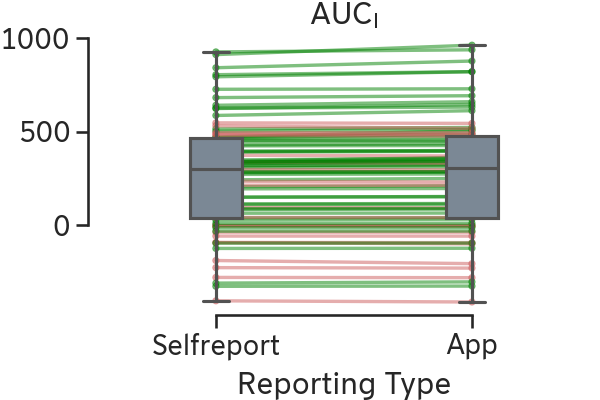

In [100]:
reporting_types = ["Selfreport", "App"]

fig, ax = paired_plot_auc(
    data=cort_features_analysis, saliva_feature="auc_i", reporting_types=reporting_types, figsize=(6, 4)
)

ax.set_ylabel(None)
fig.suptitle(None)
ax.set_title("$AUC_I$")
fig.tight_layout(pad=0)

for path in [img_path, paper_img_path]:
    bp.utils.file_handling.export_figure(fig, "img_pairedplot_auci_abstract", path, ["pdf", "png"], dpi=300)

## Time Unit Information

### Load Data

In [70]:
cort_path = export_path.joinpath("cortisol_samples_processed_all_reporting_types.csv")
cort_samples = load_cortisol_samples_reporting_times(cort_path)
# rename condition
cort_samples.head()

date  \
subject night night_id condition   reporting_type sample              
AB19E   0     AB19E_0  Known Alarm Naive          S1     2019-11-18   
                                                  S2     2019-11-18   
                                                  S3     2019-11-18   
                                                  S4     2019-11-18   
                                                  S5     2019-11-18   

                                                              wake_onset  \
subject night night_id condition   reporting_type sample                   
AB19E   0     AB19E_0  Known Alarm Naive          S1     0 days 05:45:00   
                                                  S2     0 days 05:45:00   
                                                  S3     0 days 05:45:00   
                                                  S4     0 days 05:45:00   
                                                  S5     0 days 05:45:00   

                                                             sample_time  \
subject night night_id condition   reporting_type sample                   
AB19E   0     AB19E_0  Known Alarm Naive          S1     0 days 05:45:00   
                                                  S2     0 days 06:00:00   
                                                  S3     0 days 06:15:00   
                                                  S4     0 days 06:30:00   
                                                  S5     0 days 06:45:00   

                                                          cortisol  \
subject night night_id condition   reporting_type sample             
AB19E   0     AB19E_0  Known Alarm Naive          S1          2.80   
                                                  S2          5.59   
                                                  S3         13.29   
                                                  S4         13.46   
                                                  S5         12.65   

                                                         time_diff_to_wake_onset  \
subject night night_id condition   reporting_type sample                           
AB19E   0     AB19E_0  Known Alarm Naive          S1             0 days 00:00:00   
                                                  S2             0 days 00:15:00   
                                                  S3             0 days 00:30:00   
                                                  S4             0 days 00:45:00   
                                                  S5             0 days 01:00:00   

                                                          time_diff_min  \
subject night night_id condition   reporting_type sample                  
AB19E   0     AB19E_0  Known Alarm Naive          S1                0.0   
                                                  S2               15.0   
                                                  S3               30.0   
                                                  S4               45.0   
                                                  S5               60.0   

                                                          time_diff_to_naive_min  
subject night night_id condition   reporting_type sample                          
AB19E   0     AB19E_0  Known Alarm Naive          S1                         0.0  
                                                  S2                         0.0  
                                                  S3                         0.0  
                                                  S4                         0.0  
                                                  S5                         0.0

### Data Preparation

In [77]:
time_unit_digits = compute_time_unit_digits(cort_samples)

time_unit_digits = time_unit_digits.reindex(reporting_types, level="reporting_type")
time_unit_digits = time_unit_digits.rename(lambda x: x.split(" ")[-1], level="reporting_type")
time_unit_digits.head()

date  \
subject night night_id condition   reporting_type sample              
AB19E   0     AB19E_0  Known Alarm Selfreport     S1     2019-11-18   
                                                  S2     2019-11-18   
                                                  S3     2019-11-18   
                                                  S4     2019-11-18   
                                                  S5     2019-11-18   

                                                              wake_onset  \
subject night night_id condition   reporting_type sample                   
AB19E   0     AB19E_0  Known Alarm Selfreport     S1     0 days 05:45:00   
                                                  S2     0 days 05:45:00   
                                                  S3     0 days 05:45:00   
                                                  S4     0 days 05:45:00   
                                                  S5     0 days 05:45:00   

                                                             sample_time  \
subject night night_id condition   reporting_type sample                   
AB19E   0     AB19E_0  Known Alarm Selfreport     S1     0 days 06:00:00   
                                                  S2     0 days 06:15:00   
                                                  S3     0 days 06:30:00   
                                                  S4     0 days 06:45:00   
                                                  S5     0 days 07:01:00   

                                                          cortisol  \
subject night night_id condition   reporting_type sample             
AB19E   0     AB19E_0  Known Alarm Selfreport     S1          2.80   
                                                  S2          5.59   
                                                  S3         13.29   
                                                  S4         13.46   
                                                  S5         12.65   

                                                         time_diff_to_wake_onset  \
subject night night_id condition   reporting_type sample                           
AB19E   0     AB19E_0  Known Alarm Selfreport     S1             0 days 00:15:00   
                                                  S2             0 days 00:30:00   
                                                  S3             0 days 00:45:00   
                                                  S4             0 days 01:00:00   
                                                  S5             0 days 01:16:00   

                                                          time_diff_min  \
subject night night_id condition   reporting_type sample                  
AB19E   0     AB19E_0  Known Alarm Selfreport     S1               15.0   
                                                  S2               30.0   
                                                  S3               45.0   
                                                  S4               60.0   
                                                  S5               76.0   

                                                          time_diff_to_naive_min  \
subject night night_id condition   reporting_type sample                           
AB19E   0     AB19E_0  Known Alarm Selfreport     S1                        15.0   
                                                  S2                        15.0   
                                                  S3                        15.0   
                                                  S4                        15.0   
                                                  S5                        16.0   

                                                          sample_minute  \
subject night night_id condition   reporting_type sample                  
AB19E   0     AB19E_0  Known Alarm Selfreport     S1                  0   
                                                  S2                  5   
    

### Histogram Plot

In [89]:
paper_img_path.resolve()

PosixPath('/Users/Richer/Documents/PhD/Projects/HealthPsychology/CARWatch/Paper/CARWatch_SamplingAccuracy_PNEC2022/img/graphical_abstract')

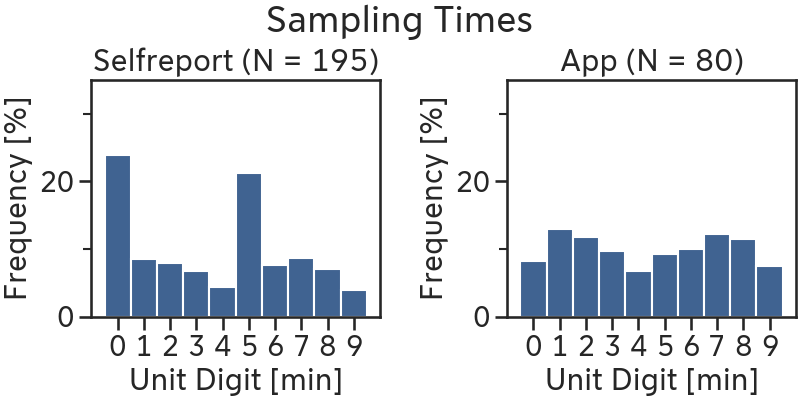

In [88]:
ylim = [0, 35]

fig, axs = time_unit_digits_histogram(
    data=time_unit_digits,
    x="sample_minute",
    reporting_type_order=reporting_types_new,
    suptitle="Sampling Times",
    ylim=ylim,
    figsize=(8, 4),
    column_title=False
)


for path in [img_path, paper_img_path]:
    bp.utils.file_handling.export_figure(fig, "img_unit_digits_sampling_time_graphical_Abstract", path, ["pdf", "png"], dpi=300)